In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'..\\torchtrainer')

# Export cells
#!python notebook2script.py segmentation.ipynb

In [2]:
# Initial imports and device setting
import torch
from torch.functional import F
from pathlib import Path
import re
import numpy as np
import scipy.ndimage as ndi
from PIL import Image
from torch.utils.data import dataloader as torch_dataloader
from functools import partial
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from torchtrainer.imagedataset import ImageDataset
from torchtrainer import img_util
from torchtrainer import transforms
from torchtrainer.models.edunet import EDUNet
from torchtrainer.models.resunet import ResUNet
from torchtrainer.learner import Learner
from torchtrainer import perf_funcs
from torchtrainer.module_util import Hooks, calculate_stats
import fastai.vision as fv


use_cuda = True

if use_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
    dev_info = torch.cuda.get_device_properties(device)
    print(dev_info)
    print(torch.cuda.memory_allocated(device))
else:
    device = torch.device('cpu')
    
def fastai_unet(train_ds, valid_ds, arch, num_classes, pretrained=True, blur_final=True, split_on=None, blur=False, 
                self_attention=False, y_range=None, last_cross=True, bottle=False, cut=None, **learn_kwargs):
    
    train_ds.c = num_classes
    valid_ds.c = num_classes
    train_ds.classes = range(num_classes)
    valid_ds.classes = range(num_classes)
    data = fv.DataBunch.create(train_ds, valid_ds, bs=1, num_workers=0)
    learn = fv.unet_learner(data, arch, pretrained=True, blur_final=True, split_on=None, blur=False, 
                                 self_attention=False, y_range=None, last_cross=True, bottle=False, cut=None, 
                                 **learn_kwargs)
    
    return learn.model

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11264MB, multi_processor_count=68)
0


## Data

In [3]:
# Data management functions for DRIVE
'''
Used in the ImageDataset class for storing the DRIVE images
'''

def name_2_label_map(img_filename):
    '''Maps image names to labels names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    label_filename : string
        Filename of the corresponding label image
    '''  
    
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = m.group(1)
    label_filename = index + '_manual1.tif'
    
    return label_filename

def name_2_mask_map(img_filename):
    '''Maps image names to mask names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    mask_filename : string
        Filename of a mask
    '''    
        
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = m.group(1)
    mask_filename = index + '_mask.gif'

    return mask_filename   

def filename_filter(img_filename, test=False):
    '''Filter DRIVE images for getting only training or test images.
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
    test : bool
        If True, the function checks if the image should be in the test set
    
    Returns
    -------
    bool
        If `test` is False, returns True if the image should be in the training set and
        False if it should be in the test set. Return values are reversed if `test` is True
    '''
    
    if test:
        return 'test' in img_filename
    else:
        return 'test' not in img_filename
    
def weight_func_small_vess(pil_img, pil_label, img_path=None, mask_threshold=0, opening_size=2,
                           background_weight=1, vessel_weight=1, small_vessel_weight=1):
    '''Weight function for DRIVE images. Thin vessels are detected an can be weighted differently than
    large vessels.
    
    Thin vessels are detected by applying a binary opening to the label image and doing a logical xor 
    between the label and opened images.
    
    Parameters
    ----------
    pil_img : PIL.Image
        Image to be weighted
    pil_label : PIL.Image
        Label of the image to be weighted
    img_path : string
        Path to a weighted image saved on disk. Defined for compatibility with ImageDataset
    mask_threshold : int
        Pixels having intensity smaller than `mask_threshold` will have weight 0
    opening_size : int
        Number of opening operations for detecting thin vessels
    background_weight : float
        Pixels having intensity larger than `mask_threshold` and set as background in `pil_label` 
        will have this weight
    vessel_weight : float
        Pixels set as vessel in `pil_label` (having value 1) and not belonging to thin 
        vessels will have this weight
    small_vessel_weight : float
        Pixels set as vessel in `pil_label` (having value 1) and belonging to thin 
        vessels will have this weight
        
    Returns
    -------
    out_pil_img : PIL.Image
        Output image
    '''      
     
    np_img = np.array(pil_img).max(axis=2)
    roi_img = np_img>=mask_threshold
    
    np_label = np.array(pil_label).astype(np.uint8)
    label_open = ndi.binary_opening(np_label, iterations=opening_size)
    label_xor = np.logical_xor(np_label, label_open)

    weight = np.zeros(np_label.shape)
    weight[roi_img==1] = background_weight
    weight[np_label==1] = vessel_weight
    weight[label_xor==1] = small_vessel_weight
    weight = weight/np.mean(weight)
    pil_weight = Image.fromarray(weight)
    
    return pil_weight

## Params

In [4]:
#Params
root_dir = Path('data/DRIVE_interpolated')
img_dir = root_dir/'images/train_val'
label_dir = root_dir/'images/labels'
test_dir = root_dir/'images/test'
mask_dir = root_dir/'mask'

params = {
            'size':(560, 560),
            'batch_size':1,
            'val_split':0.2,
            'epochs':60,
            'lr':0.001,
            'channel':None,           # If None, use all three channels
            'pretrained':True,
            'lr_sched_step':100,      # Every lr_sched_step epochs, learning rate is decreased by lr_sched_gamma
            'lr_sched_gamma':0.1,
            'weight_dict':{'mask_thresh':0, #50,    # Values used for weighting the loss function
                           'back_weight':1, #15,
                           'vess_weitht':2, #25,
                           'small_vess_weight':255}
         }

## Training

In [5]:
# Create dataloaders

from functools import partial

# Create functions for using in the dataset creation
img_opener_partial = partial(img_util.pil_img_opener, channel=params['channel'])
label_opener_partial = partial(img_util.pil_img_opener, is_label=True)
weight_dict = params['weight_dict']
weight_func_partial = partial(weight_func_small_vess, mask_threshold=weight_dict['mask_thresh'], 
                              background_weight=weight_dict['back_weight'], vessel_weight=weight_dict['vess_weitht'], 
                              small_vessel_weight=weight_dict['small_vess_weight'])


# Image transformations
#imgaug_seq = iaa.Sequential([
                             #iaa.Identity(),
                             #iaa.Resize({"height": params['size'][0], "width": params['size'][1]}),
#                            ])
imgaug_seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

transform_funcs = transforms.seq_pil_to_imgaug_to_tensor(imgaug_seq)+[transforms.TransfNormalize(True, False)]

# Create ImageDataset instance
dataset = ImageDataset(img_dir, label_dir, name_2_label_map=name_2_label_map, filename_filter=filename_filter, 
                       img_opener=img_opener_partial, label_opener=label_opener_partial, transforms=transform_funcs)
                       #weight_func=weight_func_partial)

dataset.check_dataset()

train_ds, valid_ds = dataset.split_train_val(params['val_split'])


# Or create a dataloader
train_dl = torch_dataloader.DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
valid_dl = torch_dataloader.DataLoader(valid_ds, batch_size=params['batch_size'], shuffle=False)

All images read


In [6]:
from fastai.vision.models import resnet34
from fastai.vision.models.unet import DynamicUnet

In [7]:
%%time
loss_func = F.cross_entropy #perf_funcs.weighted_cross_entropy #F.nll_loss

if params['channel'] is None: 
    num_channels = 3
else:
    num_channels = 1

#model = ResUNet(num_channels=num_channels, num_classes=2) #, use_res_block=True)
#model = fastai_unet(train_ds, valid_ds, fv.models.resnet34, num_classes=2, pretrained=params['pretrained'])
resnet = resnet34(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-2])
model = DynamicUnet(resnet, n_classes=2, img_size=(1130, 1168))  # Versão antiga
#unet = DynamicUnet(module, n_out=2, img_size=(1130, 1168))     # Versão nova
model.to("cuda:0")
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params['lr_sched_step'], gamma=params['lr_sched_gamma'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, 
                                                steps_per_epoch=len(train_dl), 
                                                epochs=params['epochs'])

learner = Learner(model, loss_func, optimizer, train_dl, valid_dl, scheduler, 
                       acc_funcs=perf_funcs.build_acc_dict(perf_funcs.get_prfa), main_acc_func='f1')

#hooks = Hooks(model, [model.encoder, model.encoder.resblock1], calculate_stats)

learner.fit(params['epochs'])

Epoch       Train loss     Valid loss            iou             f1           prec            rec


E:\Miniconda3\lib\site-packages\torch\optim\lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


    0            0.684          0.501          0.044          0.080          0.476          0.045
    1            0.578          0.504          0.496          0.662          0.702          0.667
    2            0.522          0.486          0.502          0.666          0.661          0.705
    3            0.491          0.503          0.514          0.674          0.593          0.829
    4            0.474          0.481          0.467          0.633          0.562          0.756
    5            0.462          0.439          0.543          0.704          0.703          0.728
    6            0.457          0.467          0.528          0.686          0.626          0.800
    7            0.461          0.484          0.526          0.687          0.582          0.842
    8            0.444          0.441          0.539          0.686          0.676          0.709
    9            0.442          0.452          0.556          0.714          0.639          0.828
   10            0.4

In [8]:
model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [12]:
from torchtrainer.models import resunet

x = dataset[0][0].unsqueeze(0).to('cuda')
x = model.encoder.conv1(x)
x = model.encoder.bn1(x)
x = model.encoder.relu(x)
print(x.shape)
x = model.encoder.resblock1(x)
print(x.shape)
x = model.encoder.resblock2(x)
print(x.shape)
x = model.encoder.resblock3(x)
print(x.shape)
x = model.encoder.resblock4(x)
print(x.shape)
x = model.encoder.resblock_mid(x)
print(x.shape)
print(x.shape)
x = model.a_mid_up(x)  
x = model.blur_mid_up(x)
x = model.sample_a4_(x)
x = model._l4(resunet.Concat(1)(x, x))      
x = model.a4_up(x)   
x = model.blur_a4_up(x)
x = model.sample_a3_(x)
x = model._l3(resunet.Concat(1)(x, x))      
x = model.a3_up(x)      
x = model.blur_a3_up(x)
x = model.sample_a2_(x)
x = model._l2(resunet.Concat(1)(x, x))      
x = model.a2_up(x)  
x = model.blur_a2_up(x)
x = model.sample_a1_(x)
x = model._l1(resunet.Concat(1)(x, x))     
x = model.final(x)

torch.Size([1, 64, 584, 565])
torch.Size([1, 64, 584, 565])
torch.Size([1, 128, 292, 283])
torch.Size([1, 256, 146, 142])
torch.Size([1, 512, 73, 71])
torch.Size([1, 1024, 37, 36])
torch.Size([1, 1024, 37, 36])


In [57]:
#Load best state
#learner.save_state(True)
learner.load_state()
model.to(device)
learner.epoch

21

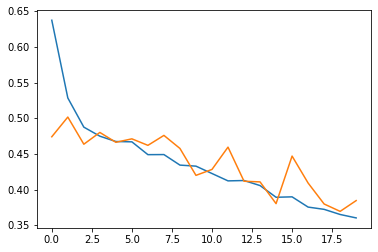

In [9]:
# Plot loss
plt.figure()
plt.plot(learner.train_loss_history)
plt.plot(learner.valid_loss_history)
#plt.ylim([0, 0.1])
#plt.figure()
#plt.plot(learner.lr_history)

In [13]:
# Test model
test_filename_filter = partial(filename_filter, test=True)

imgaug_seq = iaa.Sequential([
    iaa.Identity()
    ])

transform_funcs = transforms.seq_pil_to_imgaug_to_tensor(imgaug_seq)+[transforms.TransfNormalize(True, False)]
test_ds = ImageDataset(test_dir, label_dir, name_2_label_map=name_2_label_map, filename_filter=test_filename_filter, 
                                img_opener=img_opener_partial, label_opener=label_opener_partial,
                                transforms=transform_funcs)

dataset.check_dataset()
test_dl = torch_dataloader.DataLoader(test_ds, batch_size=1, shuffle=False)

accs = learner.test(test_dl)
print(accs)

All images read
[tensor(0.5110), tensor(0.6748), tensor(0.5562), tensor(0.8775)]


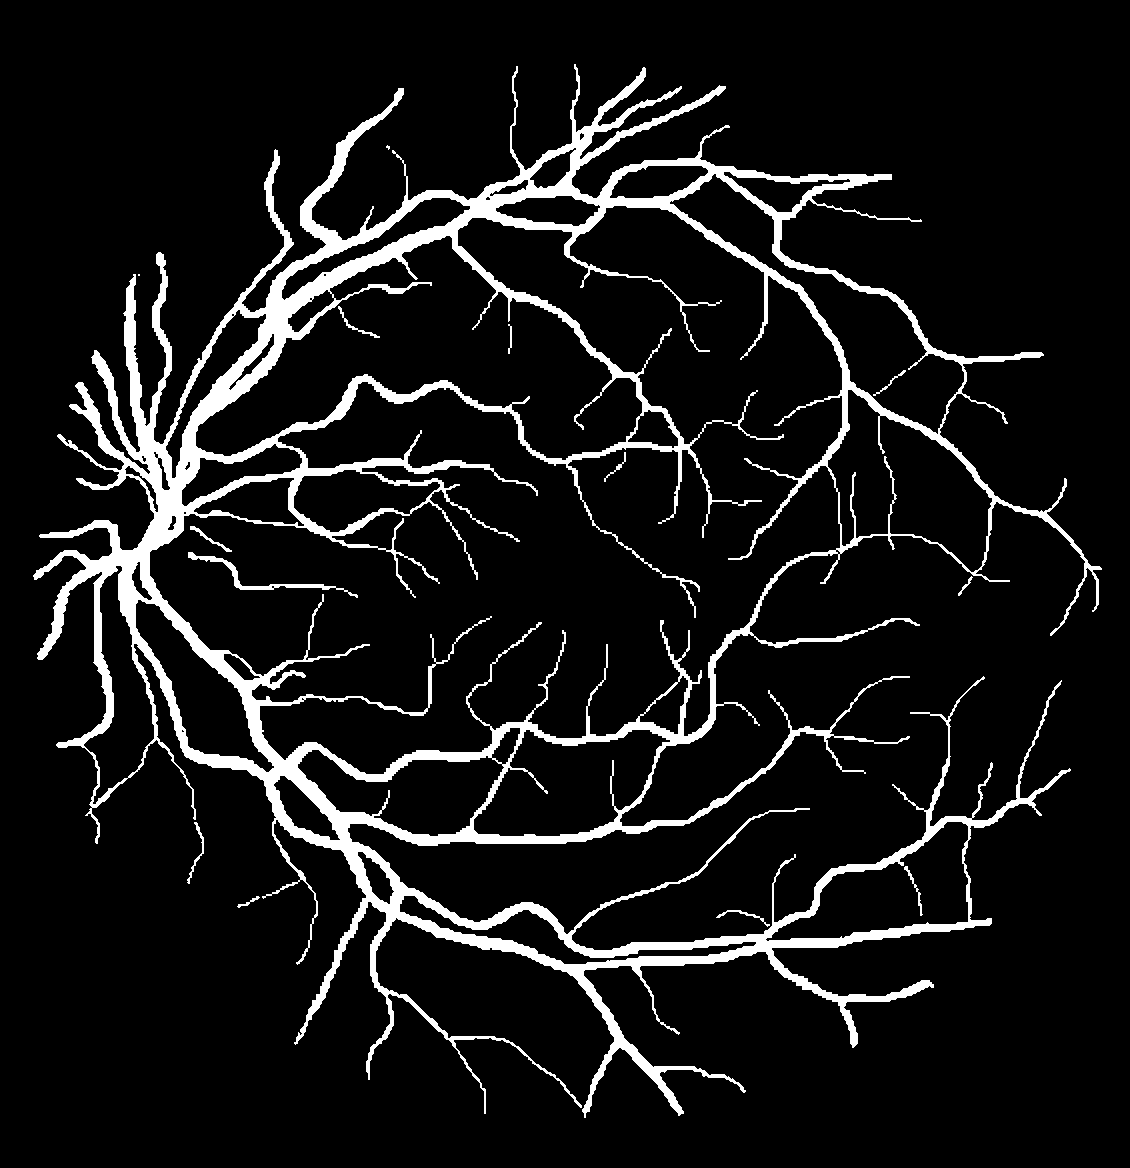

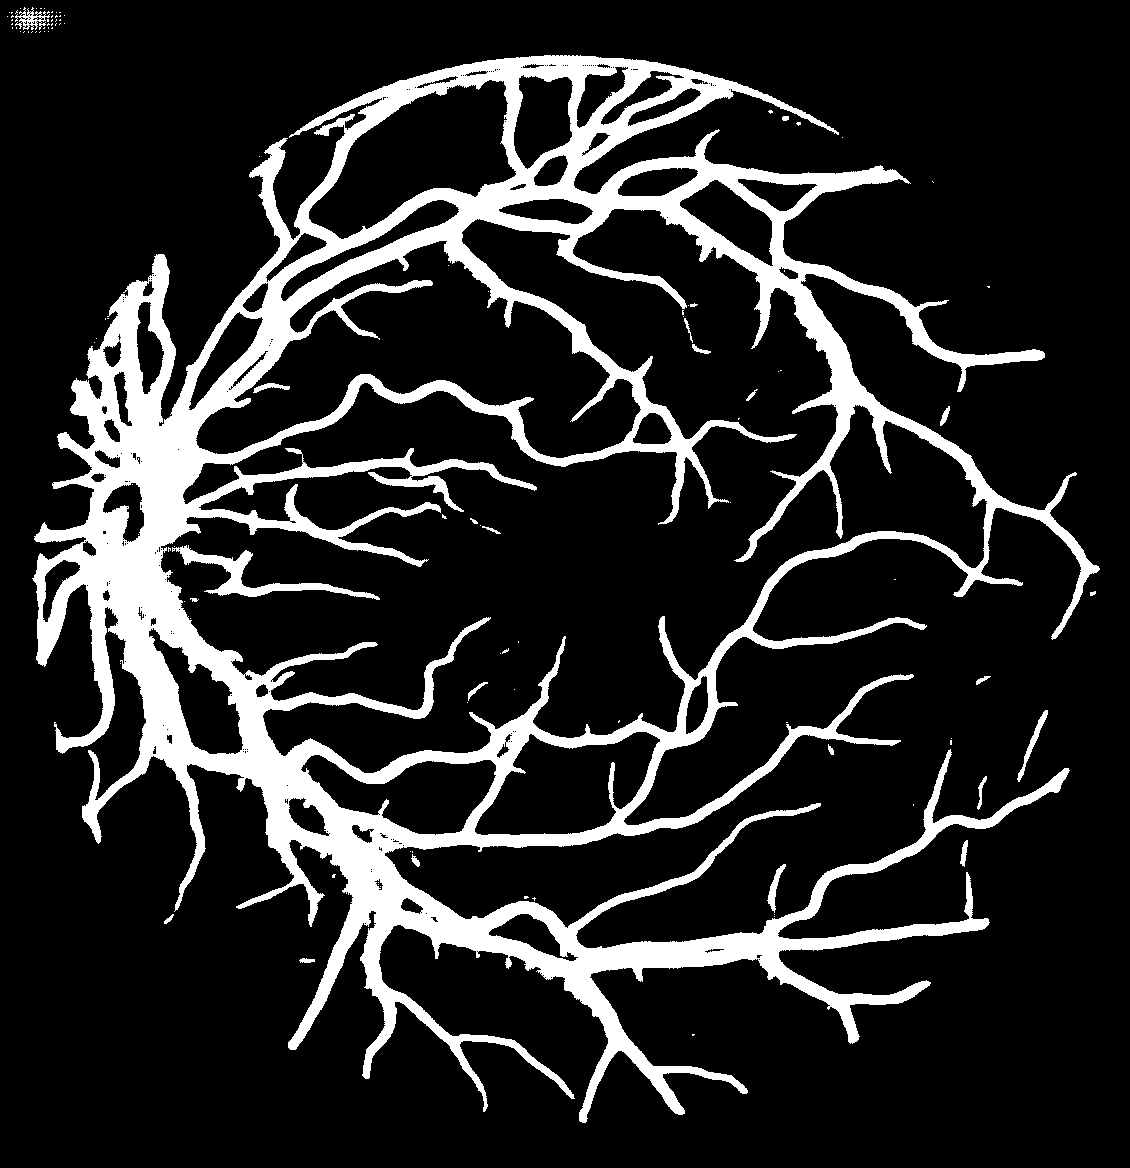

In [14]:
# Show predictions
xb, yb = test_ds[0]
bin_pred, _ = learner.pred(xb.unsqueeze(0), yb.unsqueeze(0), return_classes=True)


img_util.show(transforms.transf_to_pil(yb.squeeze().to(torch.uint8)), True)
img_util.show(transforms.transf_to_pil(bin_pred[0]), True)

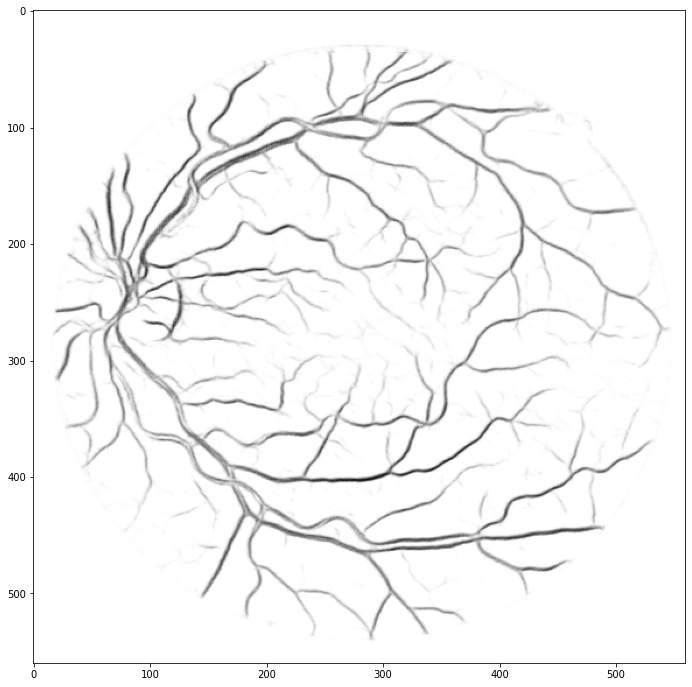

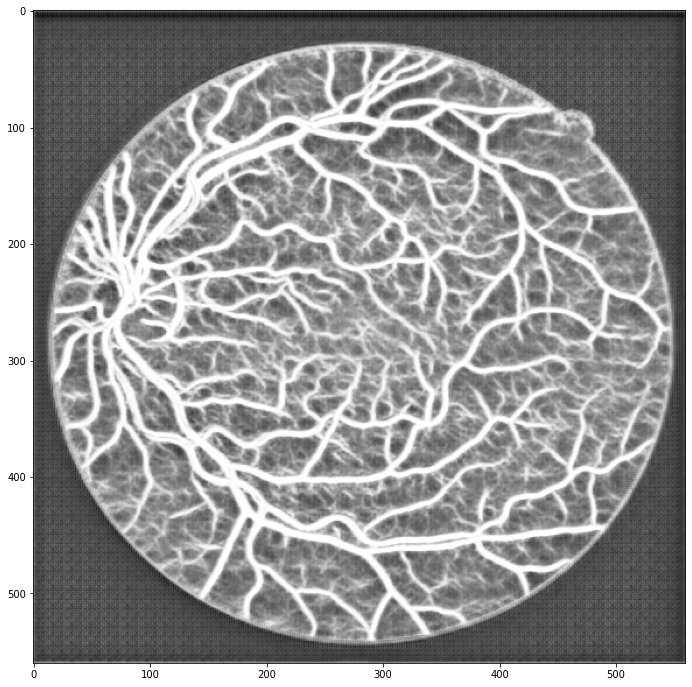

In [70]:
# Show predictions
xb, yb = test_ds[0]
pred, _ = learner.pred(xb.unsqueeze(0), yb.unsqueeze(0))

plt.figure(figsize=[12,12])
plt.imshow(pred[0,0].cpu(), 'gray')
plt.figure(figsize=[12,12])
plt.imshow(pred[0,1].cpu(), 'gray')

In [64]:
pred

tensor([[[[-4.5948e-02, -1.3163e-02, -6.3918e-03,  ..., -6.3553e-03,
           -1.1215e-02, -2.9105e-02],
          [-1.4126e-02, -4.6797e-03, -5.9605e-04,  ..., -1.6055e-03,
           -1.1399e-03, -1.4653e-02],
          [-6.4690e-03, -6.9571e-04, -2.1458e-04,  ..., -2.4700e-04,
           -2.0838e-04, -2.5468e-03],
          ...,
          [-4.5073e-03, -7.0524e-04, -4.9806e-04,  ..., -4.6682e-04,
           -6.7997e-04, -5.2392e-03],
          [-1.5918e-02, -2.2202e-03, -1.3175e-03,  ..., -1.3986e-03,
           -8.6594e-04, -1.0283e-02],
          [-1.4721e-02, -2.7292e-02, -5.7244e-03,  ..., -4.7288e-03,
           -4.8540e-03, -2.6040e-02]],

         [[-3.1031e+00, -4.3369e+00, -5.0559e+00,  ..., -5.0616e+00,
           -4.4961e+00, -3.5514e+00],
          [-4.2668e+00, -5.3669e+00, -7.4252e+00,  ..., -6.4351e+00,
           -6.7773e+00, -4.2304e+00],
          [-5.0440e+00, -7.2707e+00, -8.4476e+00,  ..., -8.3067e+00,
           -8.4768e+00, -5.9742e+00],
          ...,
     

## Example predictions

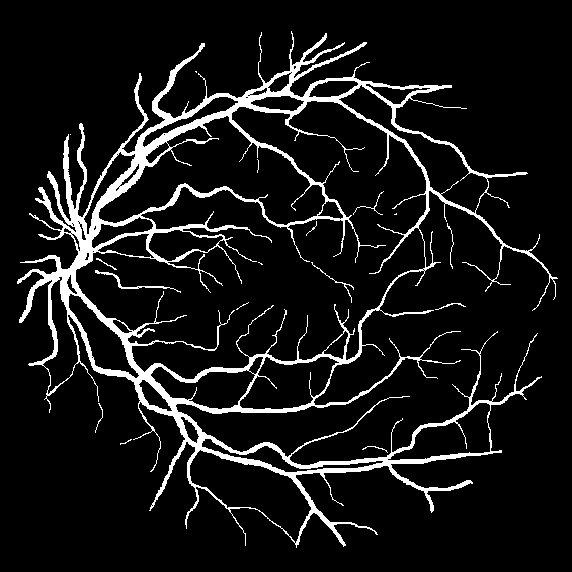

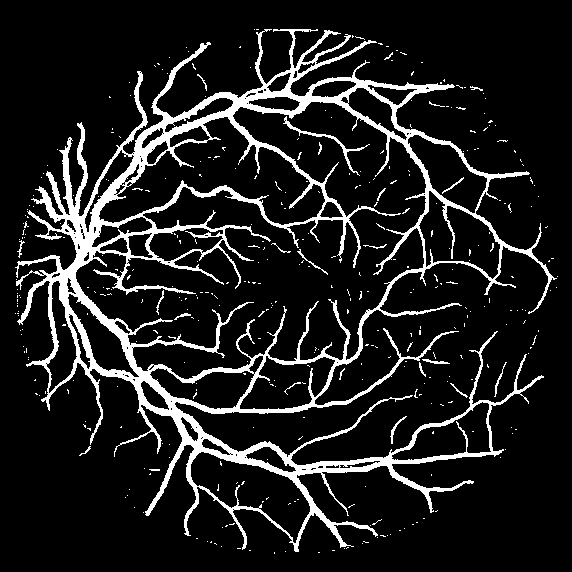

In [52]:
# For 
#'weight_dict':{'mask_thresh':0, #50,   
#               'back_weight':1, #15,
#               'vess_weitht':2, #25,
#               'small_vess_weight':255}
xb, yb = test_ds[0]
bin_pred, _ = learner.pred(xb.unsqueeze(0), yb.unsqueeze(0), return_img=True)


show(tensor_2_pil(yb.squeeze()), True)
show(tensor_2_pil(bin_pred), True)

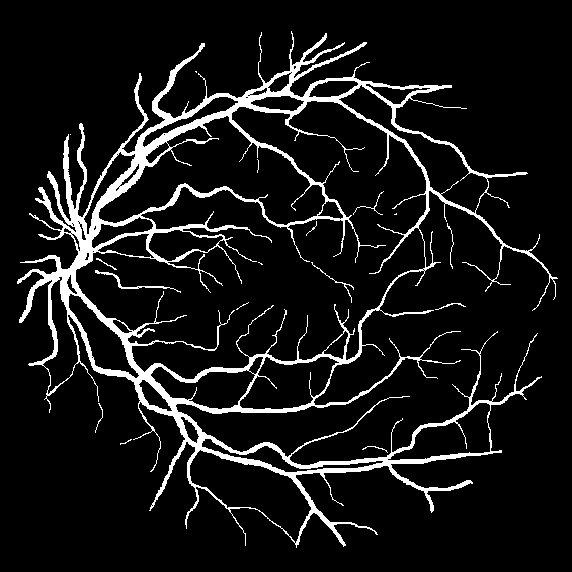

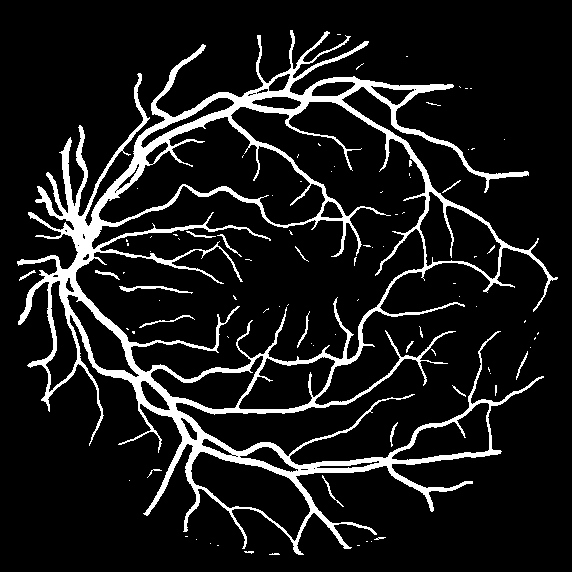

In [40]:
xb, yb = test_ds[0]
bin_pred, _ = learner.pred(xb.unsqueeze(0), yb.unsqueeze(0), return_img=True)


show(tensor_2_pil(yb.squeeze()), True)
show(tensor_2_pil(bin_pred), True)

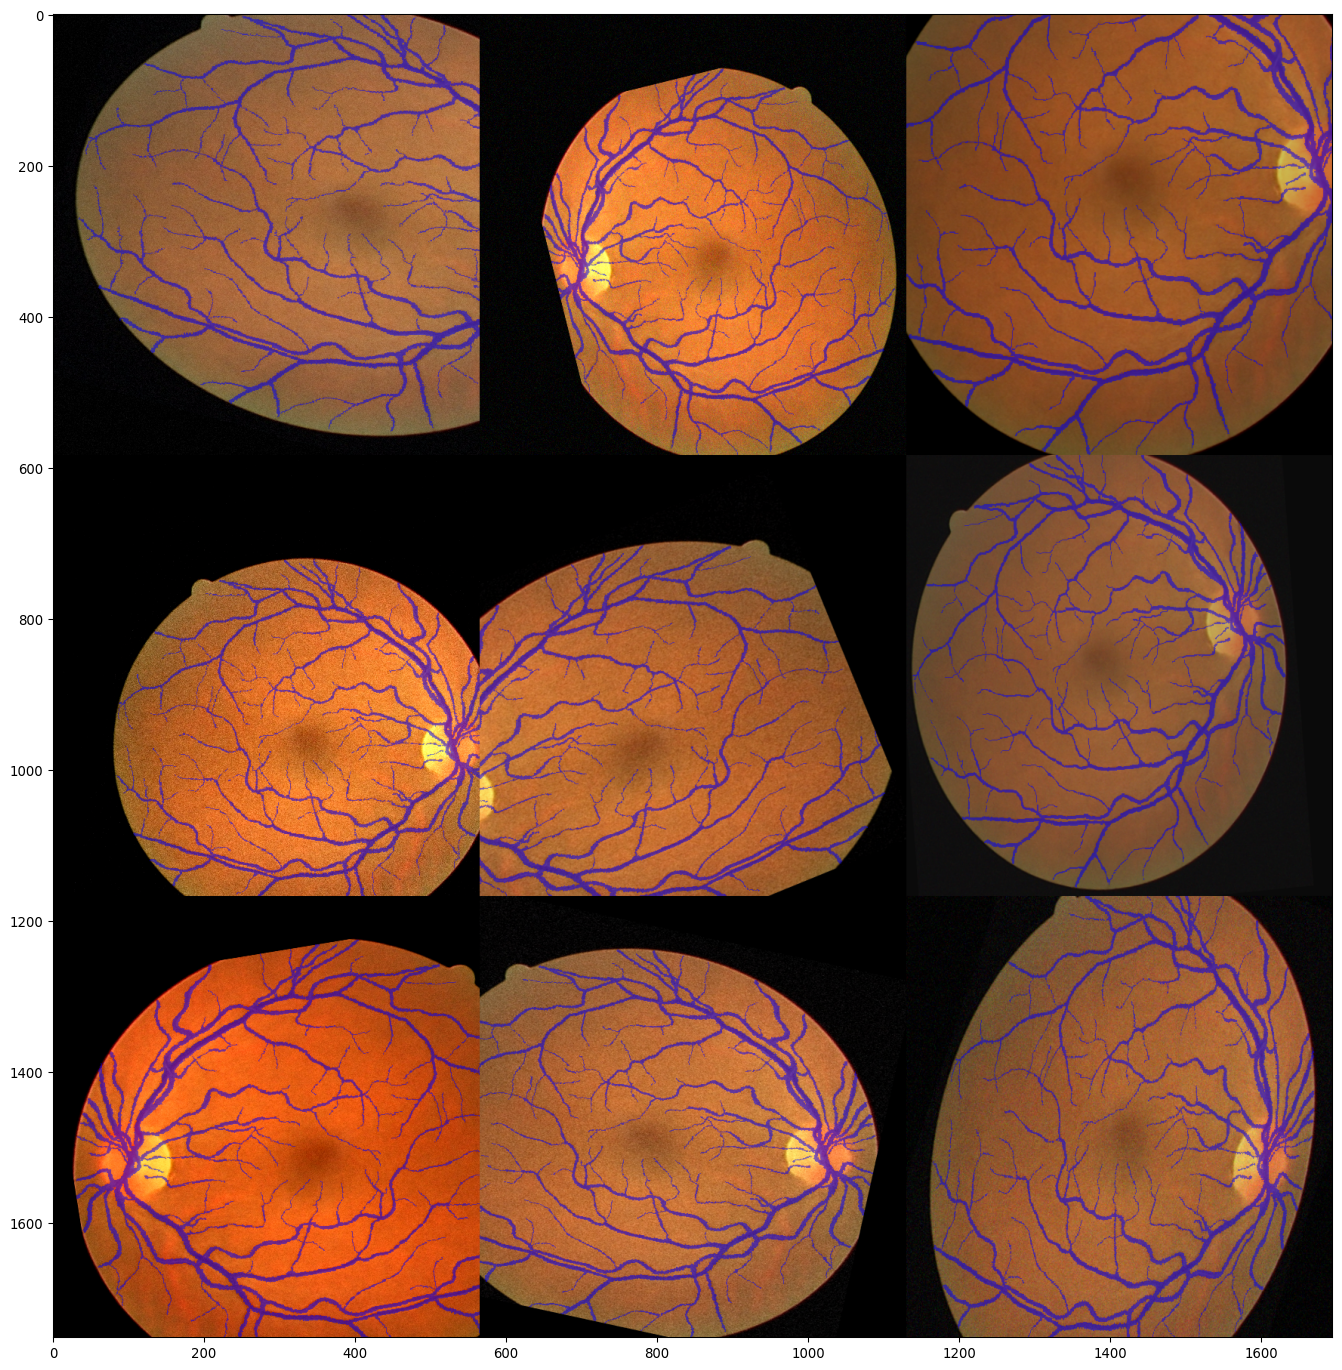

In [47]:
import numpy as np



ia.seed(1)

dataset = ImageDataset(img_dir, label_dir, name_2_label_map=name_2_label_map, 
                       img_opener=img_opener_partial, label_opener=label_opener_partial)
img, seg = map(np.array, dataset[0])

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

segmap = ia.SegmentationMapsOnImage(seg, img.shape)
image_aug, segmap_aug = zip(*[seq(image=img, segmentation_maps=segmap) for _ in range(9)])
ia.show_grid([segmap_aug[i].draw_on_image(image_aug[i], colors=[[0,0,0],[0,0,255]], alpha=0.5)[0] for i in range(len(segmap_aug))])

# End

In [7]:
model = ResUNet(num_channels=3, num_classes=2) #, use_res_block=True)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

In [14]:
p=list(model.parameters())

In [25]:
p = list(model.named_parameters())

In [7]:
model = ResUNet(num_channels=3, num_classes=2) #, use_res_block=True)

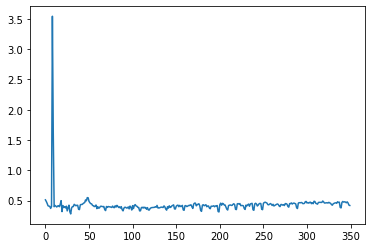

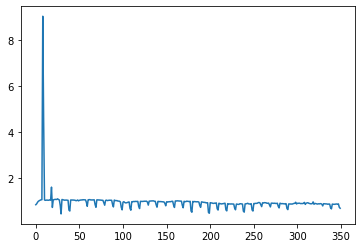

In [17]:
plt.plot(hooks.storage['encoder']['mean'])
plt.figure()
plt.plot(hooks.storage['encoder']['std'])

In [18]:
#r.size: iteravel e função
class TensorShape(tuple):

    def __new__ (cls, *args):
        return super(TensorShape, cls).__new__(cls, args)
        
    def __call__(self, dim=None):
        
        if dim is None:
            return torch.Size(self)
        else:
            return self[dim]

In [22]:
t = torch.tensor([1, 2, 3])

In [41]:
t = (1, 2, 3)

In [19]:
t = TensorShape(35, 40)

In [21]:
t(0)

35